**Group Members**


    Vengadesh S (2021fc04424) 
    Aiswarya S Parvathi (2021fc04430) 
    Nipun Gupta (2021fc04426)

Problem Statement: Generate Image Captions using CNN+LSTM

For this problem statement, we have worked on the Flickr dataset

We will first install and import the opendatasets library to download the dataset

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od

In [3]:
# URL of the dataset on kaggle website
dataset = r"https://www.kaggle.com/datasets/adityajn105/flickr8k"
WORKING_DIR='/kaggle/working'

In [4]:
# Downloading the dataset
od.download(dataset)
#Kaggle creds - {"username":"nipungupta26","key":"7800b6f2327a2db633fe1d14f04280a5"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nipungupta26
Your Kaggle Key: ··········


100%|██████████| 1.04G/1.04G [00:48<00:00, 22.8MB/s]


In [5]:
# Directory of the downloaded datasets in
data_dir = r'flickr8k/Images'

Importing the required libraries

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Listing out the images in the dataset
images = os.listdir(data_dir)

In [8]:
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
import cv2

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [9]:
# Checking the GPU available
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
# Loading the captions
with open(r'flickr8k/captions.txt', 'r') as f:
  next(f)
  captions_doc = f.read()

In [11]:
# create mapping of image to captions
mapping = {}

count = 0

# process lines
for line in tqdm(captions_doc.split('\n')):
  count = count + 1
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = ' '.join(caption)
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(list(mapping.keys()))

8091

In [13]:
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

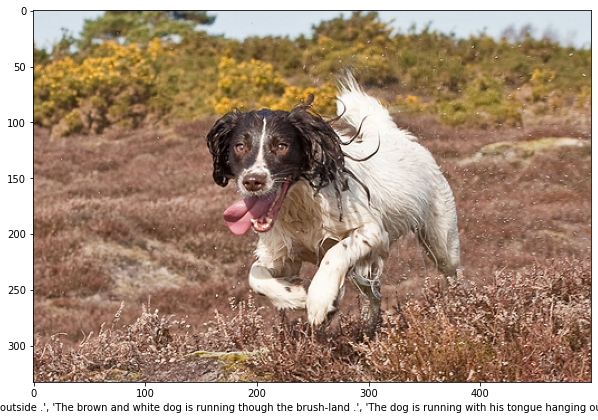

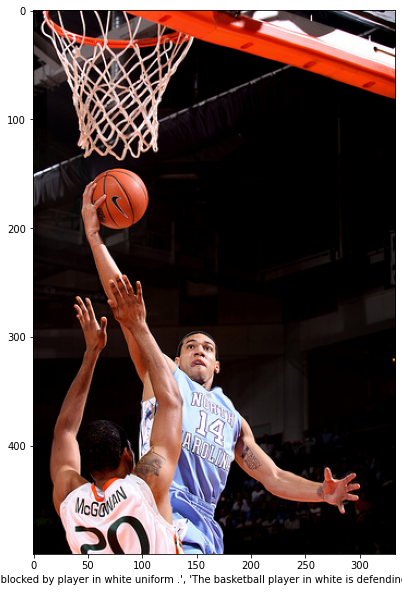

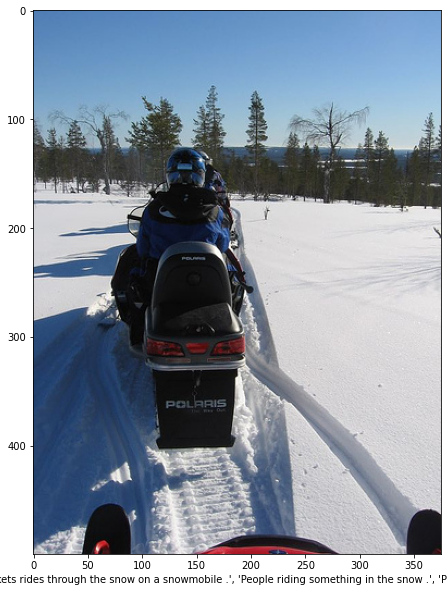

In [14]:
# Plotting at least two samples and their captions (use matplotlib/seaborn/any other library)
for i in range(3):
  plt.figure(figsize=(10,10))
  img = cv2.imread(r'flickr8k/Images/' + images[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for j in list(mapping.keys()):
    if images[i][:-4] in j:
      x = str(images[i][:-4])
      break
  plt.xlabel(mapping[x])
  plt.imshow(img)

**Extracting Image features**

In [15]:
# load the pretrained VGG16 model
model = VGG16()
#VGG16 is a convolutional neural network trained on a subset of the ImageNet dataset, a collection of over 14 million images belonging to 22,000 categories

553467096/553467096 [==============================] - 24s 0us/step


In [16]:
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# We have written -2 because we don ot need to fully connected layer of VGG16 model. We just need the previous layers in order to extract the feature results

In [17]:
# summarize the model
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
#extract features from image
features = {}
directory =  os.path.join(data_dir, 'train2017')

**Converting the data into the correct format which could be used for the DL model**

In [21]:
count = 0

for img_name in tqdm(os.listdir(data_dir)):
  count = count + 1
  # load the image from file
  img_path = data_dir + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  # (224, 224) will be the size of the resized image

  # Converting the image pixel to a numpy array
  image= img_to_array(image)

  # Reshaping the data for the model to extract the features 
  image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

  # Preparing the image for the VGG model
  image = preprocess_input(image)

  # Extracting the features
  feature = model.predict(image, verbose=0)

  # getting the image id
  image_id = img_name.split('.')[0]

  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [22]:
# Storing/Pickling the features in a file
pickle.dump(features, open('features.pk1','wb' ))

In [23]:
# Unplickling the features
with open('features.pk1', 'rb') as f:
  features = pickle.load(f)

In [24]:
len(features)

8091

In [25]:
features

{'3335097235_538f4777c3': array([[0.        , 0.03157511, 0.3333587 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '3285214689_f0219e9671': array([[0.        , 1.4988127 , 2.2663944 , ..., 0.        , 0.42719623,
         0.        ]], dtype=float32),
 '437527058_189f2a7eef': array([[1.0581365, 0.       , 0.       , ..., 0.       , 0.       ,
         3.3727064]], dtype=float32),
 '3727740053_3baa94ffcb': array([[0.        , 0.        , 0.60116386, ..., 0.        , 3.32566   ,
         1.359345  ]], dtype=float32),
 '1235681222_819231767a': array([[3.4826126 , 0.59856796, 0.8465279 , ..., 0.        , 0.7018813 ,
         0.        ]], dtype=float32),
 '1093716555_801aacef79': array([[0.       , 0.       , 0.       , ..., 1.8561056, 0.       ,
         0.       ]], dtype=float32),
 '156967462_72db9b722c': array([[1.8252808, 2.8266847, 0.       , ..., 0.       , 3.26032  ,
         0.       ]], dtype=float32),
 '3628043835_9d9bd595a7': array([[1.7018834 , 3.622819

**Preprocess Text Data**

In [26]:
# Now we will preprocess the captions
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      #Take one caption at a time
      caption = captions[i]
      #Preprocessing steps
      #Convert to lower case
      caption = caption.lower()
      #delete digit, special characters
      caption = caption.replace('[^A-Za-z]', '')
      # Remove additional spaces
      caption = caption.replace('\s+', ' ')
      # Add start and end tags to the caption
      caption = 'startseq ' + ' '.join(word for word in caption.split() if len(word)>1) + ' endseq'
      captions[i] = caption

In [27]:
# Before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [28]:
# preprocess the text
clean(mapping)

In [29]:
# After preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [30]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [31]:
len(all_captions)

40455

In [32]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [33]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [34]:
vocab_size

8485

In [35]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [36]:
# Train test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
split
train = image_ids[:split]
test = image_ids[split:]

In [37]:
# create data generator to get data in batch (avoids sessions crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode the output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          #print('features[key] : ', features[key])
          #print('features[key][0] : ', features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0 

In [41]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LeakyReLU, PReLU, ELU, Dropout

**Model Creation**

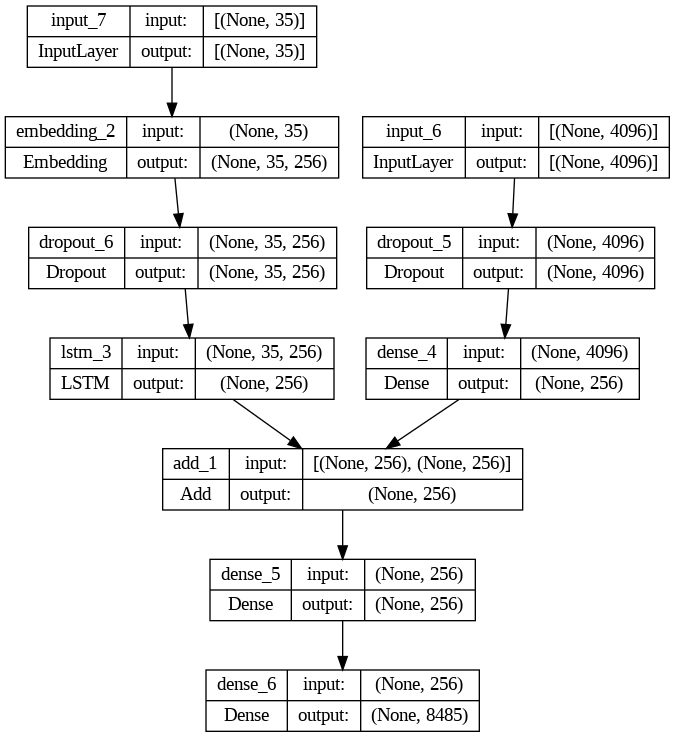

In [42]:
# Encoder model
# image feature layers
# If we see the output of the VGG16 model that was created earlier, the output shape is (None, 4096). So the input shape of the below model will (4096,)
inputs1 = Input(shape = (4096, ))

# Introducing a dropout of 0.4 to prevent overfitting
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
# The relu activation function prevents vanishing gradient problem

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# We have set mask_zero = True because we are padding the sequences
se2 = Dropout(0.4)(se1)
# Introducing 2 layers of LSTM 
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
# The softmax acitvation function gives probabilities of the respective target classes as output

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
'''The adam optimization algorithm is a further extension of stochastic gradient descent to update network weights during training. Unlike maintaining 
a single learning rate through training in SGD, Adam optimizer updates the learning rate for each network weight individually

Categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels. 
The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, 
is converted into categorical encoding'''


# plot the model
plot_model(model, show_shapes=True)

In [43]:
# Train the model
epochs = 2
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  classifier_nn = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 53s 464ms/step - loss: 4.4865


**Generate captions for the image**

In [44]:
def idx_to_word(integer, token):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [45]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  int_text = '<start>'
  #print(int_text)
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([int_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    int_text = int_text + " " + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return int_text

In [46]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)


# calculate BLEU score
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.2583941605839416
BLEU-2: 0.1445543056273581


**Visualize the results**

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
  #load the image
  
  image_id = image_name.split('.')[0]
  img_path = os.path.join(r'flickr8k/', "Images", image_name)
  image = Image.open(img_path)
  captions = mapping[image_id]
  print('------------Actual-------------')
  for caption in captions:
    print(caption)
  #predict the caption
  y_pred = predict_caption(model,features[image_id], tokenizer, max_length)
  print('-----------Predicted-----------')
  print(y_pred)
  plt.imshow(image)

------------Actual-------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
-----------Predicted-----------
<start> two two dogs dogs playing on the grass endseq


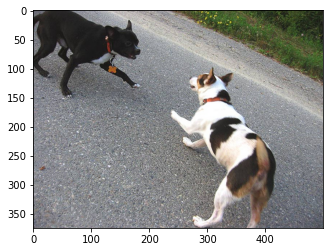

In [50]:
image_name = "1001773457_577c3a7d70.jpg"
generate_caption(image_name)